In [2]:
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit


def exp_model(t, y0, k):
    return y0 * np.exp(k * t)

def get_doubling_time(df, col):
    df2 = df.dropna()
    coef, _ = curve_fit(
        exp_model, xdata=df2.Year - df2.Year.min(), ydata=df2[col]
    )
    y0, k = coef
    return np.log(2) / k

In [ ]:
wf = pd.read_csv("data/wildlife.csv").query("Year > 1999")

print(f"Doubling time: {get_doubling_time(wf, 'Widlife_images'):.2f} years")

wf.head()

Doubling time: 2.24 years


,Year,Widlife_images,cameras
0,2025,97766341.0,219896.0
1,2024,NaN,NaN
2,2023,NaN,NaN
3,2022,40997103.0,42510.0
4,2021,27294703.0,30419.0


In [18]:
phylomedb = pd.read_csv("data/phylomedb.csv")

print(f"Doubling time: {get_doubling_time(phylomedb, 'trees'):.2f} years")

phylomedb.head()

Doubling time: 3.02 years


,Year,trees
0,2022,8000000
1,2014,1500000
2,2011,416983
3,2008,172324


In [19]:
gb = pd.read_csv("data/genbank.tsv", sep="\t")

gb.Date = pd.to_datetime(gb.Date, format="%b %Y")

gb["Sequences.Total"] = gb["Sequences"] + gb["Sequences.1"]

gb["Year"] = gb.Date.dt.year

print(f"Doubling time: {get_doubling_time(gb, 'Sequences.Total'):.2f} years")

gb

Doubling time: 3.02 years


,Release,Date,Bases,Sequences,Bases.1,Sequences.1,Sequences.Total,Year
0,3.0,1982-12-01,680338,606,NaN,NaN,NaN,1982
1,14.0,1983-11-01,2274029,2427,NaN,NaN,NaN,1983
2,20.0,1984-05-01,3002088,3665,NaN,NaN,NaN,1984
3,24.0,1984-09-01,3323270,4135,NaN,NaN,NaN,1984
4,25.0,1984-10-01,3368765,4175,NaN,NaN,NaN,1984
...,...,...,...,...,...,...,...,...
228,265.0,2025-02-01,5415448651743,255669865,3.564398e+13,4.152691e+09,4.408361e+09,2025
229,266.0,2025-04-01,5794509308815,257038531,3.729406e+13,4.234652e+09,4.491691e+09,2025
230,267.0,2025-06-01,5234752089196,258002002,3.838479e+13,4.294973e+09,4.552975e+09,2025
231,268.0,2025-08-01,5676067778413,258320620,4.039043e+13,4.441331e+09,4.699652e+09,2025


In [20]:
pdb = pd.read_csv("data/pdb.csv").query("Year >= 2000")

cols = ["Total Number of Entries Available", "Number of Structures Released Annually"]

pdb.loc[:, cols] = pdb.loc[:, cols].apply(lambda x: x.str.replace(",", "").astype(int))

print(f"Doubling time: {get_doubling_time(pdb, 'Total Number of Entries Available'):.2f} years")

pdb.head()

Doubling time: 7.87 years


,Year,Total Number of Entries Available,Number of Structures Released Annually
0,2025,212656,14469
1,2024,198187,12545
2,2023,185642,12079
3,2022,173563,11766
4,2021,161797,10362


In [21]:
merged = pd.merge(
    gb.groupby("Year", as_index=False).max().rename(columns={"Sequences.Total": "Genbank"}).loc[:, ["Year", "Genbank"]],
    pdb.rename(columns={"Total Number of Entries Available": "PDB"}).loc[
        :, ["Year", "PDB"]
    ],
    left_on="Year",
    right_on="Year",
    how="outer",
).merge(
    wf.rename(columns={"Widlife_images": "Wildlife Images"}).loc[:, ["Year", "Wildlife Images"]],
    left_on="Year",
    right_on="Year",
    how="outer",
).merge(
    phylomedb.rename(columns={"trees": "PhylomeDB"}).loc[:, ["Year", "PhylomeDB"]],
    left_on="Year",
    right_on="Year",
    how="outer",
)

merged_melt = merged.melt(
    id_vars=["Year"],
    value_vars=["Genbank", "PDB", "Wildlife Images", "PhylomeDB"],
    var_name="Database",
    value_name="Counts",
)

merged_melt

,Year,Database,Counts
0,1982,Genbank,NaN
1,1983,Genbank,NaN
2,1984,Genbank,NaN
3,1985,Genbank,NaN
4,1986,Genbank,NaN
...,...,...,...
171,2021,PhylomeDB,NaN
172,2022,PhylomeDB,8000000.0
173,2023,PhylomeDB,NaN
174,2024,PhylomeDB,NaN


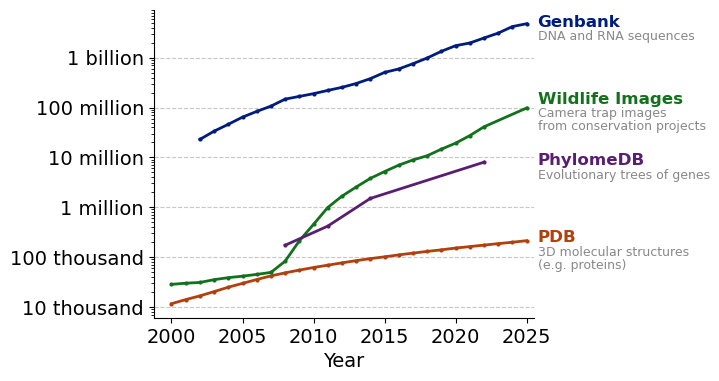

In [22]:

def human_format(x, pos):
    if x < 1e3:
        return f"{int(x)}"
    elif x < 1e6:
        return f"{int(x/1e3)} thousand"
    elif x < 1e9:
        return f"{int(x/1e6)} million"
    else:
        return f"{int(x/1e9)} billion"

with plt.style.context({"font.size": 14}):
    palette = sns.color_palette("dark")[:5]
    palette.remove(palette[3])


    fig, ax = plt.subplots(figsize=(8, 4))
    sns.lineplot(
        x="Year",
        y="Counts",
        hue="Database",
        data=merged_melt,
        color="k",
        palette=palette,
        markers=True,
        dashes=False,
        marker="o",
        markersize=3,
        linewidth=2,
        markeredgecolor="none",
        ax=ax,
    )
    ax.set_yscale("log")
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(human_format))
    ax.set_ylabel("")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    sns.despine()

    ax.legend_.remove()

    # Define legend data with descriptions and y-positions
    # Adjust these y_pos values to align with where lines end on the right side
    legend_data = [
        ("Genbank", "DNA and RNA sequences", 0.95),
        ("PDB", "3D molecular structures\n(e.g. proteins)", 0.25),
        (
            "Wildlife Images",
            "Camera trap images\nfrom conservation projects",
            0.7,
        ),
        ("PhylomeDB", "Evolutionary trees of genes", 0.5),
    ]

    # Get line colors from the plot
    line_colors = {}
    for line in ax.get_lines():
        label = line.get_label()
        if label and label != "_nolegend_":
            line_colors[label] = line.get_color()

    # Position settings for legend
    x_pos = 1.01  # Starting x position (right of plot)

    for name, desc, y_pos in legend_data:
        # Draw line segment for legend
        # Add database name (bold, black)
        ax.text(
            x_pos,
            y_pos + 0.01,
            name,
            transform=ax.transAxes,
            fontsize=12,
            fontweight="bold",
            verticalalignment="center",
            color=line_colors.get(name, "gray"),
        )

        # Add description (gray, smaller, below name)
        ax.text(
            x_pos,
            y_pos - 0.015,
            desc,
            transform=ax.transAxes,
            fontsize=9,
            color="#888888",
            verticalalignment="top",
            linespacing=1.0,
        )

    # Adjust figure to accommodate legend
    plt.subplots_adjust(right=0.6)
    ax.set_xlim(right=2025.5)

    plt.show()

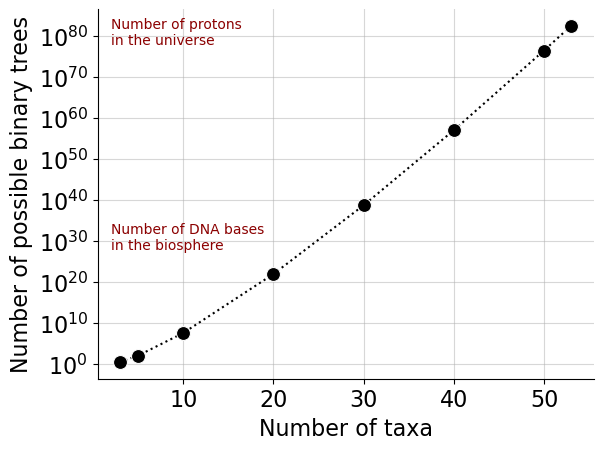

In [116]:
with plt.style.context({"font.size": 16}):

    df = pd.read_csv("data/phylotrees.csv", comment="#")

    sns.lineplot(x="n", y="trees", data=df, color="k", marker="o", linestyle="dotted", markersize=10)
    sns.despine()
    plt.text(2, 1e+28, "Number of DNA bases\nin the biosphere", color="darkred", ha="left", fontsize=10)
    plt.text(2, 1e+78, "Number of protons\nin the universe", color="darkred", ha="left", fontsize=10)
    plt.yscale("log")
    ax = plt.gca()
    exponents = np.arange(0, 90, 10)
    ticks = 10.0 ** exponents
    ax.set_yticks(ticks)
    ax.set_yticklabels([rf"$10^{{{e}}}$" for e in exponents])
    plt.xlabel("Number of taxa")
    plt.ylabel("Number of possible binary trees")
    plt.grid(alpha=0.5)

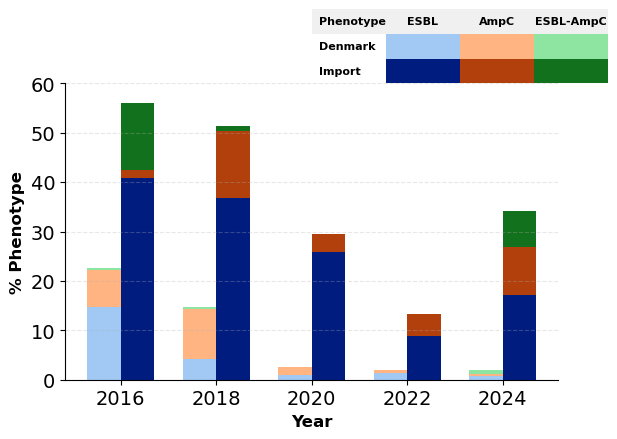

In [ ]:
df = pd.read_csv("data/danmap_broiler_meat_clean.csv", sep=";").rename(
    columns={
        "year": "Year",
        "origin": "Origin",
        "ESC_phenotype": "Phenotype",
        "pct_ESC": "Percentage",
    }
).dropna()

# Pivot the data for stacking
pivot_df = df.pivot_table(
    index=["Year", "Origin"], columns="Phenotype", values="Percentage", fill_value=0
)

with plt.style.context({"font.size": 14}):
    # Set up the plot
    fig, ax = plt.subplots()

    # Get unique years and origins
    years = df["Year"].unique()
    origins = df["Origin"].unique()
    phenotypes = df["Phenotype"].unique()

    # Set bar width and positions
    bar_width = 0.35
    x = np.arange(len(years))

    # Define colors for phenotypes (light for Local, dark for Import)
    colors_local = sns.color_palette("pastel")[:3]  # Light blue, orange, green
    colors_import = sns.color_palette("dark")[:3]  # Dark blue, orange, green

    # Plot stacked bars for each origin
    for i, origin in enumerate(origins):
        offset = bar_width * (i - 0.5)
        bottom = np.zeros(len(years))
        colors = colors_local if origin == "Denmark" else colors_import

        for j, phenotype in enumerate(phenotypes):
            values = []
            for year in years:
                try:
                    val = pivot_df.loc[(year, origin), phenotype]
                except KeyError:
                    val = 0
                values.append(val)

            ax.bar(
                x + offset,
                values,
                bar_width,
                bottom=bottom,
                color=colors[j],
                edgecolor="none",
                linewidth=0.5,
            )
            bottom += values

    # Customize the plot
    ax.set_xlabel("Year", fontsize=12, fontweight="bold")
    ax.set_ylabel("% Phenotype", fontsize=12, fontweight="bold")
    # ax.set_title(
    #     "Phenotype Distribution by Origin and Year", fontsize=14, fontweight="bold"
    # )
    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.set_ylim(0, 60)
    ax.grid(axis="y", alpha=0.3, linestyle="--")

    # Create the table with correct number of rows (header + data rows)
    n_origins = len(origins)
    n_phenotypes = len(phenotypes)
    table = ax.table(
        cellText=[[""] * (n_phenotypes + 1) for _ in range(n_origins + 1)],
        cellLoc="center",
        loc="upper left",
        bbox=[0.5, 1.0, 0.6, 0.25],
    )

    # Customize table cells
    table.auto_set_font_size(False)
    table.set_fontsize(8)

    for key, cell in table.get_celld().items():
        cell.set_linewidth(0)

    # Set headers
    table[(0, 0)].set_text_props(weight="bold", ha="left")
    table[(0, 0)].get_text().set_text("Phenotype")
    table[(0, 0)].set_facecolor("#f0f0f0")

    for j, phenotype in enumerate(phenotypes):
        table[(0, j + 1)].set_text_props(weight="bold")
        table[(0, j + 1)].get_text().set_text(phenotype)
        table[(0, j + 1)].set_facecolor("#f0f0f0")

    # Set origin labels and color patches
    for i, origin in enumerate(origins):

        table[(i + 1, 0)].get_text().set_text(origin)
        table[(i + 1, 0)].set_text_props(weight="bold", ha="left")

        for j, phenotype in enumerate(phenotypes):
            colors = colors_local if origin == "Denmark" else colors_import
            table[(i + 1, j + 1)].set_facecolor(colors[j])
            table[(i + 1, j + 1)].set_edgecolor("none")
            table[(i + 1, j + 1)].set_linewidth(1)

    plt.tight_layout()
    sns.despine()
    plt.show()

                         Virus  Year    Deaths  World population  \
0            Spanish influenza  1918  50000000        1830000000   
1                Hantaan virus  1951     46430        2584034261   
2  South American hantaviruses  1956      1990        2822443282   
3      Kyasanur forest disease  1957      1000        2873306090   
4               H2N2 influenza  1957   1100000        2873306090   

   Deaths per million  Continents  Deaths_per_100M  
0            27322.00           6        2732200.0  
1               18.00           1           1800.0  
2                0.71           1             71.0  
3                0.35           1             35.0  
4              383.00           6          38300.0  


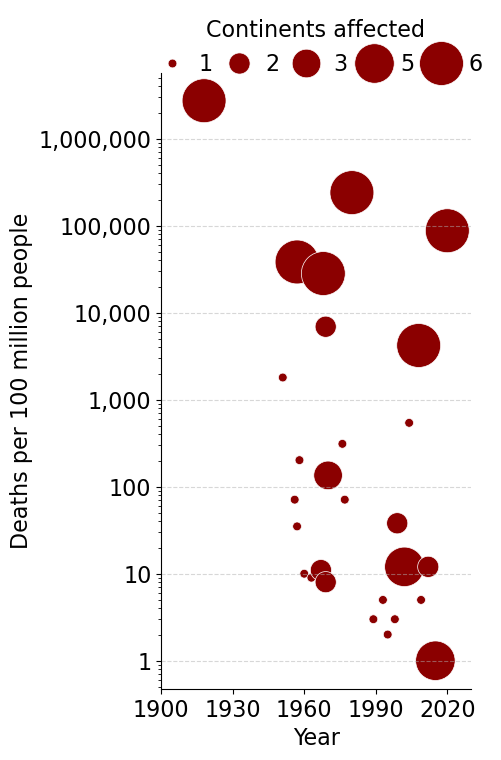

In [45]:
pandemics = pd.read_csv("data/pandemics.csv", sep=";")

pandemics["Deaths_per_100M"] = pandemics["Deaths per million"] * 100

print(pandemics.head())

with plt.style.context({"font.size": 16}):
    plt.figure(figsize=(4, 8))
    sns.scatterplot(
        x="Year",
        y="Deaths_per_100M",
        data=pandemics,
        size="Continents",
        color="darkred",
        sizes=(40,1000)
    )
    plt.grid(alpha=0.5, axis="y", linestyle="--")
    ax = plt.gca()
    ax.set_yscale("log")
    # import matplotlib
    # logfmt = matplotlib.ticker.LogFormatterExponent(base=10.0, labelOnlyBase=True)
    # ax.yaxis.set_major_formatter(logfmt)
    sns.despine()
    plt.legend(
        bbox_to_anchor=(1.1, 1.12), title="Continents affected", loc="upper right",
        frameon=False, ncol=5, columnspacing=0.2, handletextpad=0.2
    )
    # Use human readable y-axis labels
    def human_format(x, pos):
        if x < 1e3:
            return f"{int(x)}"
        elif x < 1e6:
            return f"{int(x/1e3)} thousand"
        elif x < 1e9:
            return f"{int(x/1e6)} million"
        else:
            return f"{int(x/1e9)} billion"
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    ax.set_ylabel("Deaths per 100 million people")
    # add ticks every 10 years
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.set_xlim(left=1910,right=2030)
    # Put 5 ticks for x-axis
    ax.set_xticks(np.linspace(1900, 2020, 5))
    # Add annotations for: COVID-19, Spanish influenza, Zika, H2N2 influenza, H3N2 influenza
    # annotations = []
    # for disease in ["COVID-19", "Spanish influenza", "Zika", "H2N2 influenza", "H3N2 influenza"]:
    #     row = pandemics[pandemics["Virus"] == disease]
    #     if not row.empty:
    #         year = row["Year"].values[0]
    #         deaths = row["Deaths"].values[0]
    #         annotations.append((disease, year, deaths))
    # for disease, year, deaths in annotations:
    #     deaths_per_100M = pandemics[pandemics["Virus"] == disease]["Deaths_per_100M"].values[0]
    #     plt.annotate(
    #         disease,
    #         xy=(year, deaths_per_100M),
    #         xytext=(year, deaths_per_100M/2),
    #         fontsize=9,
    #         color="black"
    #     )

    plt.show()

In [42]:
np.linspace(1900, 2020, 5)

array([1900., 1930., 1960., 1990., 2020.])

In [273]:
pandemics.sort_values(by="Deaths_per_100M", ascending=False)

,Virus,Year,Deaths,World population,Deaths per million,Continents,Deaths_per_100M
0,Spanish influenza,1918,50000000,1830000000,27322.00,6,2732200.0
15,HIV,1980,10700000,4458003514,2400.00,6,240000.0
28,COVID-19,2020,7000000,7794798739,875.00,6,87500.0
4,H2N2 influenza,1957,1100000,2873306090,383.00,6,38300.0
9,H3N2 influenza,1968,1000000,3551599127,282.00,6,28200.0
10,Lassa fever,1969,250000,3625680627,69.00,1,6900.0
24,H1N1 influenza,2008,284000,6789088686,42.00,6,4200.0
1,Hantaan virus,1951,46430,2584034261,18.00,2,1800.0
23,Chikungunya,2004,35000,6461159389,5.42,1,542.0
13,Ebola,1976,12930,4154666864,3.11,1,311.0


In [8]:
stock["Unit"].value_counts()

Unit
An         192
1000 An    128
Name: count, dtype: int64

In [14]:
"An".split("An")[0]

''

In [79]:
stock = pd.read_csv("data/livestock.csv", sep=",").replace("Swine / pigs", "Pigs")

def get_unit(x):
    split_x = x.split("An")[0].strip()
    try:
        return int(split_x)
    except ValueError:
        return 1

stock["Total"] = stock["Value"] * stock["Unit"].apply(get_unit)

stock = stock.loc[:, ["Year", "Item", "Total"]]

stock.head()

,Year,Item,Total
0,1961,Cattle,942122097
1,1962,Cattle,957121229
2,1963,Cattle,970331395
3,1964,Cattle,987525060
4,1965,Cattle,1008857195


In [78]:
pop = (
    pd.read_csv("data/worldpop.csv", index_col=0)
    .loc["World"]
    .drop(["Country Code", "Indicator Name", "Indicator Code"])
    .dropna()
    .to_frame(name="Total")
    .reset_index(names="Year")
    .astype(int)
    .assign(Item="Human")
)

pop.head()

,Year,Total,Item
0,1960,3021512598,Human
1,1961,3062768116,Human
2,1962,3117372187,Human
3,1963,3184063049,Human
4,1964,3251253200,Human


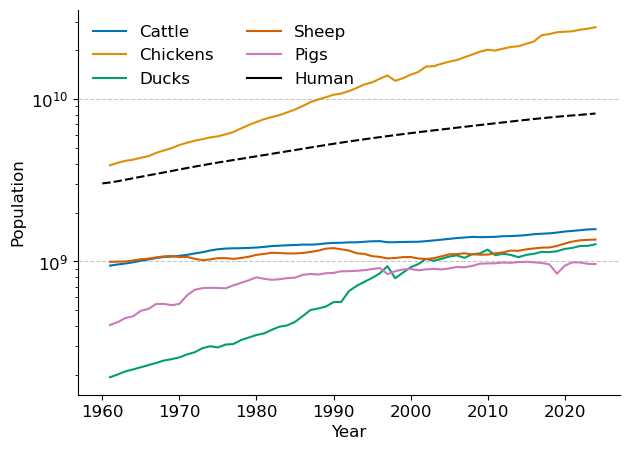

In [94]:
concat = pd.concat([stock, pop])

palette = sns.color_palette("colorblind")[:stock["Item"].nunique()] + ["k"]
concat["is_human"] = concat["Item"] == "Human"

with plt.style.context({"font.size": 12}):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.lineplot(x="Year", y="Total", hue="Item", style="is_human", palette=palette, data=concat)
    plt.yscale("log")
    plt.legend(title="", ncol=2)
    # Remove legends for is_human
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for handle, label in zip(handles, labels):
        if label not in ["True", "False", "is_human", "Item"]:
            new_handles.append(handle)
            new_labels.append(label)
    plt.gca().legend(new_handles, new_labels, title="", ncol=2, loc="upper left", frameon=False)
    plt.xlabel("Year")
    plt.ylabel("Population")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    sns.despine()

In [ ]:
pop = (
    pd.read_csv("data/worldpop.csv", index_col=0)
    .loc["World"]
    .drop(["Country Code", "Indicator Name", "Indicator Code"])
    .dropna()
    .to_frame(name="Total")
    .reset_index(names="Year")
    .astype(int)
    .assign(Item="Human")
)

merged = pd.merge(
    stock,
    pop,
    on="Year",
    how="inner"
)

sns.lineplot(x="Year", y="Total", hue="Item", palette="colorblind", data=stock)
plt.yscale("log")
plt.legend(title="")
plt.xlabel("Year")
plt.ylabel("")
sns.despine()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year_x,Unit,Value,Flag,Flag Description,Note,Total,Year_y,Human
0,QCL,Crops and livestock products,1,World,5111,Stocks,2111,Cattle,1961,1961,An,942122097,A,Official figure,NaN,942122097,1961,3062768116
1,QCL,Crops and livestock products,1,World,5111,Stocks,2111,Cattle,1962,1962,An,957121229,A,Official figure,NaN,957121229,1962,3117372187
2,QCL,Crops and livestock products,1,World,5111,Stocks,2111,Cattle,1963,1963,An,970331395,A,Official figure,NaN,970331395,1963,3184063049
3,QCL,Crops and livestock products,1,World,5111,Stocks,2111,Cattle,1964,1964,An,987525060,A,Official figure,NaN,987525060,1964,3251253200
4,QCL,Crops and livestock products,1,World,5111,Stocks,2111,Cattle,1965,1965,An,1008857195,A,Official figure,NaN,1008857195,1965,3318997522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,QCL,Crops and livestock products,1,World,5111,Stocks,2140,Swine / pigs,2020,2020,An,939793606,A,Official figure,NaN,939793606,2020,7854748424
316,QCL,Crops and livestock products,1,World,5111,Stocks,2140,Swine / pigs,2021,2021,An,986359758,A,Official figure,NaN,986359758,2021,7920514854
317,QCL,Crops and livestock products,1,World,5111,Stocks,2140,Swine / pigs,2022,2022,An,984854015,A,Official figure,NaN,984854015,2022,7989545217
318,QCL,Crops and livestock products,1,World,5111,Stocks,2140,Swine / pigs,2023,2023,An,965707560,A,Official figure,NaN,965707560,2023,8064057930


/tmp/ipykernel_986339/76442375.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


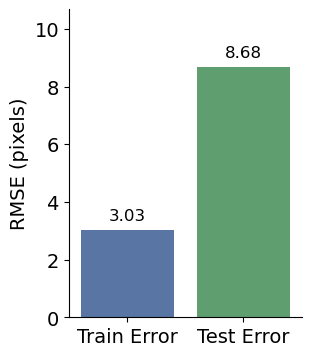

In [5]:
train_error = 3.03 # pixels
test_error = 8.68 # pixels

# Bar plot in seaborn

with plt.style.context({"font.size": 14}):
    fig, ax = plt.subplots(figsize=(3, 4))
    sns.barplot(
        x=["Train Error", "Test Error"],
        y=[train_error, test_error],
        palette=["#4c72b0", "#55a868"],
        edgecolor="none",
        ax=ax
    )
    ax.set_ylabel("RMSE (pixels)")
    ax.set_ylim(0, max(train_error, test_error) + 2)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=12,
            color="black",
            xytext=(0, 5),
            textcoords="offset points"
        )
    sns.despine()
    plt.show()

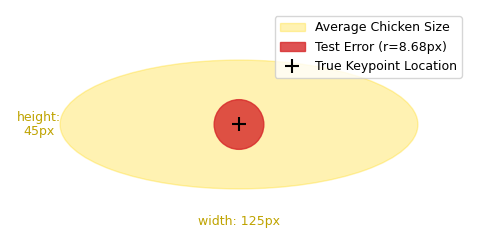

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


with plt.style.context({"font.size": 14}):
    # Data
    rmse_train = 3.03
    rmse_test = 8.68
    chicken_w, chicken_h = 125, 45  # The chicken dimensions

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    # -----------------------------
    # PLOT 2: Chicken vs Error (The Simplified View)
    # -----------------------------
    ax_vis = ax

    # Center everything at (0,0)
    # Draw the Chicken
    chicken = patches.Ellipse(
        (0, 0),
        width=chicken_w,
        height=chicken_h,
        color="#FFD700",
        alpha=0.3,
        label="Average Chicken Size",
    )

    # Draw the specific Test Error (Radius = RMSE)
    error_circle = patches.Circle(
        (0, 0),
        radius=rmse_test,
        color="#d62728",
        alpha=0.8,
        label=f"Test Error (r={rmse_test}px)",
    )

    ax_vis.add_patch(chicken)
    ax_vis.add_patch(error_circle)

    # Add "True Keypoint" marker in the center
    ax_vis.scatter(
        [0], [0], c="black", marker="+", s=100, label="True Keypoint Location"
    )

    # Annotate dimensions for clarity
    # Width annotation
    ax_vis.annotate(
        f"width: {chicken_w}px",
        xy=(0, -35),
        xytext=(0, -35),
        ha="center",
        fontsize=9,
        color="#bfa300",
    )
    # Height annotation
    ax_vis.annotate(
        f"height:\n{chicken_h}px",
        xy=(-70, 0),
        xytext=(-70, 0),
        va="center",
        ha="center",
        fontsize=9,
        color="#bfa300",
    )

    # Setup the view
    limit = 80  # Enough to see the 125px width (62.5 radius) + margin
    ax_vis.set_xlim(-limit, limit)
    ax_vis.set_ylim(-limit / 2, limit / 2)  # Aspect ratio adjustment
    ax_vis.set_aspect("equal")

    ax_vis.legend(loc="upper right", fontsize=9)
    ax_vis.axis("off")  # Turn off the grid/box completely for a clean look
    # ax_vis.grid(alpha=0.5)

    plt.tight_layout()
    sns.despine()
    plt.show()